[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239974-lesson-4-research-assistant)

# 리서치 어시스턴트 (Research Assistant)

## 복습

지금까지 LangGraph의 몇 가지 주요 주제를 다루었습니다:

  * 메모리 (Memory)
  * 휴먼-인-더-루프 (Human-in-the-loop)
  * 제어 가능성 (Controllability)

이제 이 개념들을 모두 합쳐 AI의 가장 인기 있는 애플리케이션 중 하나인 **리서치 자동화**에 도전해 보겠습니다.

리서치는 종종 분석가에게 맡겨지는 힘든 작업이며, AI는 이 과정을 돕는 데 상당한 잠재력을 가지고 있습니다.

하지만 리서치에는 맞춤화(customization)가 필요합니다. 정제되지 않은 LLM의 결과물은 실제 의사 결정 워크플로우에 적합하지 않은 경우가 많기 때문입니다.

AI 기반의 맞춤형 [리서치 및 보고서 생성](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/#reports-over-rag) 워크플로우는 이 문제를 해결할 유망한 방법입니다.

## 목표

우리의 목표는 챗 모델을 기반으로 리서치 과정을 맞춤화하는 경량의 다중 에이전트(multi-agent) 시스템을 구축하는 것입니다.

`소스 선택`

  * 사용자는 리서치에 사용할 입력 소스를 자유롭게 선택할 수 있습니다.

`계획 수립`

  * 사용자가 주제를 제공하면, 시스템은 각각 하나의 하위 주제에 집중하는 AI 분석가 팀을 생성합니다.
  * 리서치가 시작되기 전, `휴먼-인-더-루프(Human-in-the-loop)`를 통해 이러한 하위 주제를 다듬게 됩니다.

`LLM 활용`

  * 각 분석가는 선택된 소스를 사용하여 전문가 AI와 심층 인터뷰를 진행합니다.
  * 이 인터뷰는 [STORM](https://arxiv.org/abs/2402.14207) 논문에서 제시된 것처럼 상세한 인사이트를 추출하기 위한 다중 턴(multi-turn) 대화로 이루어집니다.
  * `서브 그래프(sub-graphs)`와 그 내부 상태를 사용하여 이러한 인터뷰 내용이 기록됩니다.

`리서치 과정`

  * 전문가 AI는 분석가의 질문에 답하기 위해 정보를 `병렬`로 수집합니다.
  * 그리고 모든 인터뷰는 `맵리듀스(map-reduce)`를 통해 동시에 진행됩니다.

`출력 형식`

  * 각 인터뷰에서 수집된 인사이트는 최종 보고서로 종합됩니다.
  * 보고서에는 맞춤형 프롬프트를 사용하여 유연한 출력 형식을 지원할 것입니다.


![Screenshot 2024-08-26 at 7.26.33 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb164d61c93d48e604091_research-assistant1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

## Setup

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [3]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [5]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 분석가 생성: 휴먼-인-더-루프 (Human-In-The-Loop)

휴먼-인-더-루프(human-in-the-loop)를 사용하여 분석가를 생성하고 검토합니다.

In [6]:
from typing import List, TypedDict
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    """분석가에 대한 정보를 담는 클래스"""

    affiliation: str = Field(
        description="분석가의 주요 소속.",
    )
    name: str = Field(description="분석가의 이름.")
    role: str = Field(
        description="주제와 관련된 분석가의 역할.",
    )
    description: str = Field(
        description="분석가의 주요 관심사, 우려 사항 및 동기에 대한 설명.",
    )

    @property
    def persona(self) -> str:
        """분석가의 페르소나를 문자열로 반환합니다."""
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    """다양한 분석가들의 관점을 담는 클래스"""

    analysts: List[Analyst] = Field(
        description="각 분석가의 역할과 소속을 포함한 전체 목록.",
    )


class GenerateAnalystsState(TypedDict):
    """분석가 생성 그래프의 상태를 정의합니다."""

    topic: str  # 리서치 주제
    max_analysts: int  # 최대 분석가 수
    human_analyst_feedback: str  # 사용자의 피드백
    analysts: List[Analyst]  # 생성된 분석가 목록

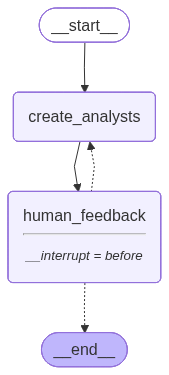

In [7]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# 분석가 생성을 위한 지침 프롬프트
analyst_instructions = """당신은 AI 분석가 페르소나 그룹을 만드는 임무를 받았습니다. 다음 지침을 주의 깊게 따르세요:

1. 먼저, 리서치 주제를 검토하세요:
{topic}
        
2. 분석가 생성을 돕기 위해 선택적으로 제공된 편집 피드백이 있다면 검토하세요: 
        
{human_analyst_feedback}
    
3. 위의 문서 및/또는 피드백을 바탕으로 가장 흥미로운 주제들을 결정하세요.
                    
4. 상위 {max_analysts}개의 주제를 선택하세요.

5. 각 주제에 분석가 한 명씩을 배정하세요."""


def create_analysts(state: GenerateAnalystsState):
    """분석가를 생성합니다."""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # 구조화된 출력을 사용하도록 LLM 설정
    structured_llm = llm.with_structured_output(Perspectives)

    # 시스템 메시지 생성
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    # 분석가 생성 요청
    analysts = structured_llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="분석가 그룹을 생성해주세요.")]
    )

    # 생성된 분석가 목록을 상태(state)에 기록
    return {"analysts": analysts.analysts}


def human_feedback(state: GenerateAnalystsState):
    """사용자 개입을 위해 중단(interrupt)이 필요한, 아무 작업도 하지 않는(no-op) 노드입니다."""
    pass


def should_continue(state: GenerateAnalystsState):
    """다음에 실행할 노드를 반환합니다."""

    # 사용자 피드백이 있는지 확인
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        # 피드백이 있으면 다시 분석가 생성
        return "create_analysts"

    # 피드백이 없으면 종료
    return END


# 노드와 엣지 추가
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback",
    should_continue,
    [
        "create_analysts",
        END,
    ],
)

# 컴파일
memory = MemorySaver()
graph = builder.compile(
    interrupt_before=["human_feedback"],
    checkpointer=memory,
)

# 그래프 시각화
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [8]:
# 입력
max_analysts = 3
topic = "에이전트 프레임워크로서 LangGraph를 채택할 때의 이점"
thread = {"configurable": {"thread_id": "1"}}

# 첫 번째 중단(interruption) 지점까지 그래프를 실행합니다.
for event in graph.stream(
    {
        "topic": topic,
        "max_analysts": max_analysts,
    },
    thread,
    stream_mode="values",
):
    # 생성된 분석가 검토
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"이름: {analyst.name}")
            print(f"소속: {analyst.affiliation}")
            print(f"역할: {analyst.role}")
            print(f"설명: {analyst.description}")
            print("-" * 50)

이름: Alice Kim
소속: Tech Research Institute
역할: Technology Adoption Specialist
설명: Alice focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes and improve efficiency in software development. Her research often highlights the competitive advantages that early adopters can gain.
--------------------------------------------------
이름: Bob Lee
소속: Data Science Solutions
역할: Data Integration Analyst
설명: Bob is an expert in data integration and is keenly interested in how LangGraph facilitates seamless data flow between different systems. He explores the technical aspects of LangGraph's architecture that enable robust data handling and integration, making it a valuable tool for complex data environments.
--------------------------------------------------
이름: Clara Zhang
소속: AI and Machine Learning Lab
역할: AI Framework Evaluator
설명: Clara evaluates various AI frameworks and their applicability in re

In [9]:
# 상태를 확인하고 다음 노드를 살펴보세요
state = graph.get_state(thread)
state.next

('human_feedback',)

In [10]:
# 이제 `human_feedback` 노드에서 사용자가 피드백을 입력한 것처럼 상태를 업데이트합니다.
graph.update_state(
    thread,
    {
        "human_analyst_feedback": "기업가적 관점을 더하기 위해 스타트업 인물을 추가해주세요."
    },
    as_node="human_feedback",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09f44a-1002-66a8-8002-1e65a793f746'}}

In [11]:
# 그래프 실행을 계속합니다.
for event in graph.stream(None, thread, stream_mode="values"):
    # 결과 검토
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"이름: {analyst.name}")
            print(f"소속: {analyst.affiliation}")
            print(f"역할: {analyst.role}")
            print(f"설명: {analyst.description}")
            print("-" * 50)

이름: Alice Kim
소속: Tech Research Institute
역할: Technology Adoption Specialist
설명: Alice focuses on the strategic benefits of adopting new technologies like LangGraph. She is particularly interested in how LangGraph can streamline processes and improve efficiency in software development. Her research often highlights the competitive advantages that early adopters can gain.
--------------------------------------------------
이름: Bob Lee
소속: Data Science Solutions
역할: Data Integration Analyst
설명: Bob is an expert in data integration and is keenly interested in how LangGraph facilitates seamless data flow between different systems. He explores the technical aspects of LangGraph's architecture that enable robust data handling and integration, making it a valuable tool for complex data environments.
--------------------------------------------------
이름: Clara Zhang
소속: AI and Machine Learning Lab
역할: AI Framework Evaluator
설명: Clara evaluates various AI frameworks and their applicability in re

In [12]:
# 만약 우리가 만족한다면, 우리는 단순히 피드백을 제공하지 않는다
further_feedack = None
graph.update_state(
    thread,
    {"human_analyst_feedback": further_feedack},
    as_node="human_feedback",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09f44a-6f68-6a98-8004-13aff1ec6c45'}}

In [13]:
# 그래프 실행을 끝까지 계속하십시오
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [14]:
final_state = graph.get_state(thread)
analysts = final_state.values.get("analysts")

In [15]:
final_state.next

()

In [16]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Dr. Emily Carter
Affiliation: Tech Research Institute
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of adopting LangGraph as an agent framework. She is particularly interested in how LangGraph can enhance the efficiency and scalability of AI models. Her research delves into the framework's ability to streamline the integration of complex AI systems, making it a preferred choice for developers looking to optimize performance.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Global Business Solutions
Role: Business Strategist
Description: Michael Thompson examines the strategic business benefits of using LangGraph. He is keen on understanding how this framework can provide competitive advantages to companies by reducing development time and costs. Michael's analysis includes case studies of businesses that have successfully implemented LangGraph to accelerate their AI initiatives and improve their mar

## 인터뷰 진행

### 질문 생성

분석가가 전문가에게 질문을 합니다.

In [17]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    """인터뷰 서브 그래프의 상태를 정의합니다."""

    max_num_turns: int  # 대화의 최대 턴(turn) 수
    context: Annotated[list, operator.add]  # 참조 문서 (소스)
    analyst: Analyst  # 질문하는 분석가
    interview: str  # 인터뷰 기록 (스크립트)
    sections: list  # Send() API를 위해 외부 상태(state)에 복제되는 최종 키


class SearchQuery(BaseModel):
    """검색 쿼리를 정의하는 클래스"""

    search_query: str = Field(
        None, description="정보 검색(retrieval)을 위한 검색 쿼리."
    )

In [18]:
# 질문 생성을 위한 지침 프롬프트
question_instructions = """당신은 특정 주제에 대해 배우기 위해 전문가를 인터뷰하는 임무를 맡은 분석가입니다.

당신의 목표는 주제와 관련된 흥미롭고 구체적인 인사이트를 도출하는 것입니다.

1. 흥미로운 점: 사람들이 놀라워하거나 미처 생각하지 못했던 인사이트.
        
2. 구체적인 점: 일반적인 내용을 피하고 전문가로부터 얻은 구체적인 예시를 포함하는 인사이트.

당신이 집중할 주제와 목표는 다음과 같습니다: {goals}
        
먼저 당신의 페르소나에 맞는 이름으로 자신을 소개한 후, 질문을 시작하세요.

주제에 대한 이해를 심화하고 다듬기 위해 계속해서 질문을 던지세요.
        
이해가 충분하다고 생각되면, "도와주셔서 정말 감사합니다!"라는 말로 인터뷰를 마무리하세요.

답변하는 내내 주어진 페르소나와 목표를 반영하여 당신의 역할을 유지하는 것을 잊지 마세요."""


def generate_question(state: InterviewState):
    """질문을 생성하는 노드입니다."""

    # 상태(state)에서 정보 가져오기
    analyst = state["analyst"]
    messages = state["messages"]

    # 질문 생성
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 생성된 질문 메시지를 상태에 기록
    return {"messages": [question]}

### 답변 생성: 병렬 처리

전문가(AI)는 질문에 답변하기 위해 여러 소스에서 **병렬로** 정보를 수집합니다.

예를 들어, 다음과 같은 방법을 사용할 수 있습니다:

  * 특정 웹사이트 (예: [`WebBaseLoader`](https://www.google.com/search?q=%5Bhttps://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/%5D\(https://python.langchain.com/v0.2/docs/integrations/document_loaders/web_base/\)) 사용)
  * 인덱싱된 문서 (예: [suspicious link removed] 사용)
  * 웹 검색
  * 위키피디아 검색

[Tavily](https://tavily.com/)와 같은 다양한 웹 검색 도구를 사용해 볼 수 있습니다.

In [19]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

In [20]:
# 웹 검색 도구
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=3)

/var/folders/z8/xfx3ln6x16x1fy6q7kpf1tzh0000gn/T/ipykernel_31990/2611384022.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [21]:
# 위키백과 검색 도구
from langchain_community.document_loaders import WikipediaLoader

이제 웹과 위키피디아를 검색하는 노드를 생성합니다.

또한 분석가의 질문에 답변하는 노드도 만들 것입니다.

마지막으로, 전체 인터뷰를 저장하고 인터뷰의 요약본("섹션")을 작성하는 노드들을 생성합니다.

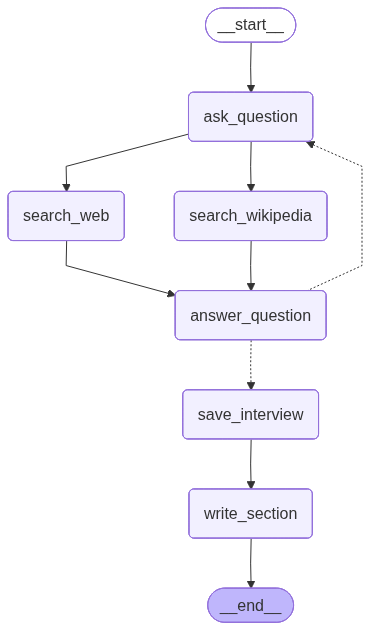

In [22]:
from langchain_core.messages import get_buffer_string

# 검색 쿼리 작성을 위한 지침
search_instructions = SystemMessage(
    content="""분석가와 전문가 사이의 대화가 주어집니다.

당신의 목표는 대화와 관련된 정보 검색(retrieval) 및/또는 웹 검색에 사용될 잘 구조화된 쿼리를 생성하는 것입니다.
        
먼저, 전체 대화를 분석하세요.

분석가가 제기한 마지막 질문에 특히 주의를 기울이세요.

이 마지막 질문을 잘 구조화된 웹 검색 쿼리로 변환하세요."""
)


def search_web(state: InterviewState):
    """웹 검색을 통해 문서를 검색합니다."""
    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # 검색 실행
    search_docs = tavily_search.invoke(search_query.search_query)

    # 결과 형식 맞추기
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_wikipedia(state: InterviewState):
    """위키피디아에서 문서를 검색합니다."""
    # 검색 쿼리 생성
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # 검색 실행
    search_docs = WikipediaLoader(
        query=search_query.search_query,
        load_max_docs=2,
    ).load()

    # 결과 형식 맞추기
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


# 답변 생성을 위한 지침
answer_instructions = """당신은 분석가에게 인터뷰를 받는 전문가입니다.

분석가의 주요 관심 분야는 다음과 같습니다: {goals}. 
        
당신의 목표는 인터뷰어가 제기한 질문에 답변하는 것입니다.

질문에 답하기 위해 다음 컨텍스트를 사용하세요:
        
{context}

질문에 답변할 때 다음 가이드라인을 따르세요:
        
1. 제공된 컨텍스트의 정보만 사용하세요.
        
2. 컨텍스트에 명시적으로 언급된 내용 이외의 외부 정보를 도입하거나 추측하지 마세요.

3. 컨텍스트에는 각 개별 문서의 주제에 해당하는 소스가 포함되어 있습니다.

4. 답변 내용 중 관련 진술 옆에 이 소스들을 포함시키세요. 예를 들어, 소스 #1의 경우 [1]을 사용합니다.

5. 답변 하단에 사용한 소스를 순서대로 나열하세요. 예: [1] 소스 1, [2] 소스 2 등
        
6. 만약 소스가 '<Document source="assistant/docs/llama3_1.pdf" page="7"/>'이라면 다음과 같이 나열하세요: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
이때 인용문에서 대괄호와 'Document source' 머리글은 생략합니다."""


def generate_answer(state: InterviewState):
    """질문에 답변하는 노드입니다."""
    # 상태 가져오기
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # 질문에 답변
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    # 메시지에 'expert'라는 이름 부여
    answer.name = "expert"

    # 상태에 추가
    return {"messages": [answer]}


def save_interview(state: InterviewState):
    """인터뷰 내용을 저장합니다."""
    # 메시지 가져오기
    messages = state["messages"]

    # 인터뷰를 하나의 문자열로 변환
    interview = get_buffer_string(messages)

    # 'interview' 키에 저장
    return {"interview": interview}


def route_messages(state: InterviewState, name: str = "expert"):
    """질문과 답변 사이의 흐름을 제어(라우팅)합니다."""
    # 메시지 가져오기
    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # 전문가 답변 수 확인
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # 전문가가 최대 턴 수보다 많이 답변하면 종료
    if num_responses >= max_num_turns:
        return "save_interview"

    # 이 라우터는 각 질문-답변 쌍 이후에 실행됩니다.
    # 마지막 질문을 가져와 토론 종료 여부 확인
    last_question = messages[-2]

    if "도와주셔서 정말 감사합니다" in last_question.content:
        return "save_interview"
    return "ask_question"


# 섹션 작성자 지침
section_writer_instructions = """당신은 전문 기술 작가입니다. 
            
당신의 임무는 주어진 소스 문서를 기반으로 짧고 이해하기 쉬운 보고서 섹션을 만드는 것입니다.

1. 소스 문서의 내용을 분석하세요:
- 각 소스 문서의 이름은 문서 시작 부분의 <Document> 태그에 있습니다.
        
2. 마크다운 형식을 사용하여 보고서 구조를 만드세요:
- 섹션 제목에는 ##를 사용하세요.
- 하위 섹션 제목에는 ###를 사용하세요.
        
3. 다음 구조에 따라 보고서를 작성하세요:
가. 제목 (## 헤더)
나. 요약 (### 헤더)
다. 출처 (### 헤더)

4. 분석가의 관심 분야를 바탕으로 흥미로운 제목을 만드세요:
{focus}

5. 요약 섹션 작성 시:
- 분석가의 관심 분야와 관련된 일반적인 배경/맥락으로 요약을 시작하세요.
- 인터뷰에서 얻은 새롭거나, 흥미롭거나, 놀라운 인사이트를 강조하세요.
- 소스 문서를 사용할 때 번호 목록을 만드세요.
- 인터뷰어나 전문가의 이름은 언급하지 마세요.
- 분량은 최대 약 400단어로 작성하세요.
- 보고서에 소스 문서의 정보를 바탕으로 번호가 매겨진 출처(예: [1], [2])를 사용하세요.
        
6. 출처 섹션 작성 시:
- 보고서에 사용된 모든 출처를 포함하세요.
- 관련 웹사이트의 전체 링크 또는 특정 문서 경로를 제공하세요.
- 각 출처는 줄바꿈으로 구분하세요. 마크다운에서 줄바꿈을 하려면 각 줄 끝에 공백 두 개를 사용하세요.
- 형식은 다음과 같습니다:

### 출처
[1] 링크 또는 문서 이름
[2] 링크 또는 문서 이름

7. 출처를 통합해야 합니다. 예를 들어, 아래는 잘못된 형식입니다:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

중복되는 출처가 없어야 합니다. 다음과 같이 간단하게 표기해야 합니다:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. 최종 검토:
- 보고서가 요구되는 구조를 따르는지 확인하세요.
- 보고서 제목 앞에 서문(preamble)을 포함하지 마세요.
- 모든 가이드라인이 지켜졌는지 확인하세요."""


def write_section(state: InterviewState):
    """보고서 섹션을 작성하는 노드입니다."""
    # 상태 가져오기
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # 수집된 소스 문서(context) 또는 인터뷰 자체(interview)를 사용하여 섹션 작성
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"이 소스를 사용하여 섹션을 작성하세요: {context}")]
    )

    # 상태에 추가
    return {"sections": [section.content]}


# 노드와 엣지 추가
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# 흐름 정의
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question", route_messages, ["ask_question", "save_interview"]
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# 인터뷰 그래프 컴파일
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(
    run_name="Conduct Interviews"
)

# 그래프 시각화
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [23]:
# 한 명의 애널리스트를 선택
analysts[0]

Analyst(affiliation='Tech Research Institute', name='Dr. Emily Carter', role='AI Framework Specialist', description="Dr. Carter focuses on the technical advantages of adopting LangGraph as an agent framework. She is particularly interested in how LangGraph can enhance the efficiency and scalability of AI models. Her research delves into the framework's ability to streamline the integration of complex AI systems, making it a preferred choice for developers looking to optimize performance.")

여기서 우리는 주제와 관련된 llama3.1 논문의 인덱스를 전달하여 인터뷰를 실행합니다.

In [26]:
from IPython.display import Markdown

# 첫 번째 분석가(analysts[0])와 2턴 동안 인터뷰를 진행합니다.
messages = [HumanMessage(content=f"{topic}에 대한 기사를 쓰고 계신다고 하셨죠?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke(
    {
        "analyst": analysts[0],
        "messages": messages,
        "max_num_turns": 2,
    },
    thread,
)

# 인터뷰 결과로 생성된 보고서 섹션을 마크다운 형식으로 출력합니다.
Markdown(interview["sections"][0])

## Enhancing AI Model Efficiency and Scalability with LangGraph

### 요약

AI 에이전트 프레임워크는 복잡한 AI 시스템을 효율적이고 확장 가능하게 만드는 데 중요한 역할을 합니다. 특히 LangGraph는 이러한 프레임워크 중에서도 복잡한 에이전틱 워크플로우를 간소화하는 데 탁월한 성능을 발휘합니다. LangGraph는 그래프 기반의 구조를 통해 상태 관리와 에이전트 조정의 복잡성을 추상화하여 개발자가 데이터 일관성과 올바른 실행 순서를 보장하는 데 집중할 수 있도록 합니다. 이는 개발 속도를 높이고 오류 발생 가능성을 줄여줍니다 [1].

LangGraph의 주요 장점 중 하나는 유연성입니다. 개발자는 자신의 에이전트 로직과 통신 프로토콜을 정의할 수 있어, 특정 용도에 맞춘 맞춤형 애플리케이션을 쉽게 만들 수 있습니다. 이는 다양한 사용자 요청을 처리할 수 있는 챗봇이나 복잡한 작업을 수행하는 멀티 에이전트 시스템을 구축하는 데 유리합니다 [2].

또한, LangGraph는 대규모 멀티 에이전트 애플리케이션의 실행을 지원하도록 설계되어 있어, 대량의 상호작용과 복잡한 워크플로를 처리할 수 있습니다. 이는 성능과 안정성이 중요한 엔터프라이즈 수준의 애플리케이션에 적합합니다. LangGraph의 내결함성은 개별 에이전트에 문제가 발생해도 애플리케이션이 계속 작동할 수 있도록 하여 시스템의 안정성과 견고성을 유지합니다 [3].

LangGraph는 LangChain의 기능을 확장하여 복잡한 에이전트 런타임 개발에 필수적인 순환 그래프를 만들고 관리할 수 있는 기능을 제공합니다. 이로 인해 개발자는 LLM을 사용하여 상태를 유지하고 여러 에이전트를 포함한 애플리케이션을 쉽게 만들 수 있습니다. 이러한 기능은 LangGraph를 AI 모델의 효율성과 확장성을 극대화하는 데 이상적인 선택으로 만듭니다 [4].

### 출처
[1] https://www.salesforce.com/kr/agentforce/ai-agents/ai-agent-frameworks/  
[2] https://data-newbie.tistory.com/997  
[3] https://cloud.google.com/discover/what-is-a-multi-agent-system?hl=ko  
[4] https://data-newbie.tistory.com/997  

### 인터뷰 병렬 처리: 맵리듀스(Map-Reduce)

`Send()` API를 사용하여 인터뷰를 병렬 처리합니다. 이 과정이 **맵(map)** 단계입니다.

그리고 그 결과들을 보고서 본문으로 통합합니다. 이 과정이 **리듀스(reduce)** 단계입니다.

### 마무리

최종 보고서에 서론과 결론을 작성하는 마지막 단계를 추가합니다.

In [27]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


class ResearchGraphState(TypedDict):
    """리서치 그래프의 상태를 정의합니다."""

    topic: str  # 리서치 주제
    max_analysts: int  # 최대 분석가 수
    human_analyst_feedback: str  # 사용자의 피드백
    analysts: List[Analyst]  # 질문하는 분석가 목록
    sections: Annotated[list, operator.add]  # Send() API를 위한 키
    introduction: str  # 최종 보고서의 서론
    content: str  # 최종 보고서의 본문
    conclusion: str  # 최종 보고서의 결론
    final_report: str  # 최종 보고서

/var/folders/z8/xfx3ln6x16x1fy6q7kpf1tzh0000gn/T/ipykernel_31990/3318893172.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


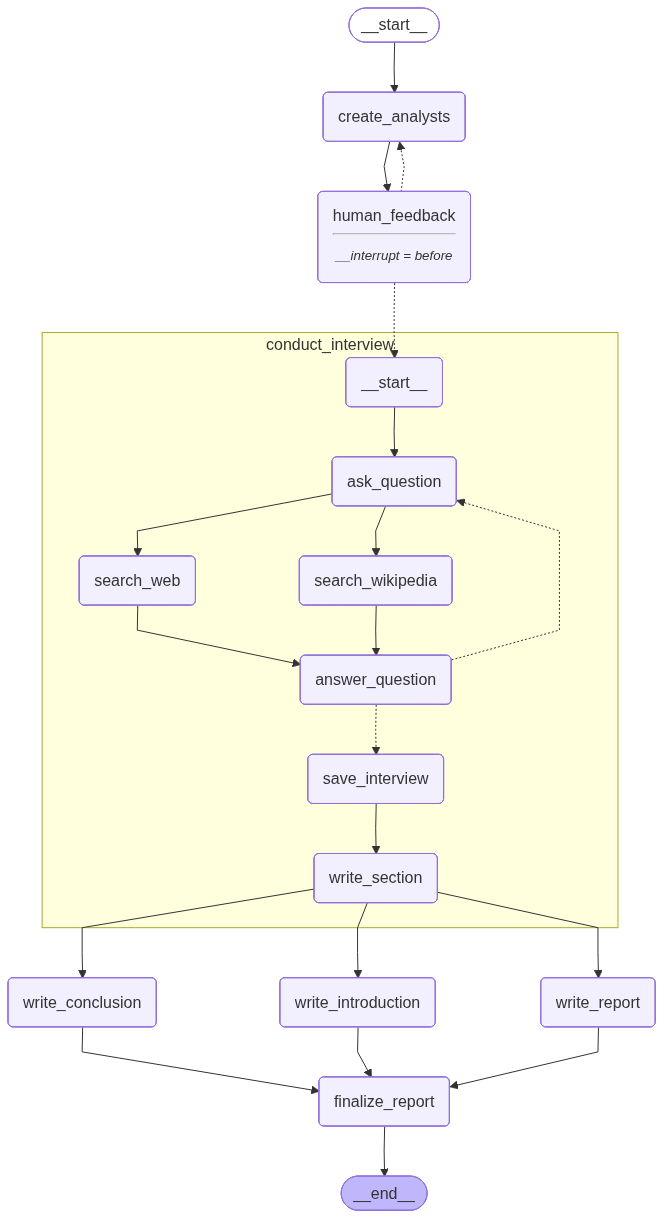

In [28]:
from langgraph.constants import Send


def initiate_all_interviews(state: ResearchGraphState):
    """Send API를 사용하여 각 인터뷰 서브 그래프를 실행하는 "맵(map)" 단계입니다."""
    # 사용자 피드백 확인
    human_analyst_feedback = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        # 피드백이 있으면 create_analysts 노드로 돌아감
        return "create_analysts"
    # 그렇지 않으면 Send() API를 통해 병렬로 인터뷰 시작
    else:
        topic = state["topic"]
        return [
            Send(
                "conduct_interview",
                {
                    "analyst": analyst,
                    "messages": [
                        HumanMessage(
                            content=f"{topic}에 대한 기사를 쓰고 계신다고 하셨죠?"
                        )
                    ],
                },
            )
            for analyst in state["analysts"]
        ]


# 보고서 작성자 지침
report_writer_instructions = """당신은 다음 전체 주제에 대한 보고서를 작성하는 기술 작가입니다:

{topic}
    
당신에게는 분석가 팀이 있습니다. 각 분석가는 두 가지 작업을 수행했습니다:

1. 특정 하위 주제에 대해 전문가와 인터뷰를 진행했습니다.
2. 발견한 내용을 메모로 작성했습니다.

당신의 임무:

1. 분석가들로부터 받은 메모 모음이 주어질 것입니다.
2. 각 메모의 인사이트에 대해 신중하게 생각하세요.
3. 모든 메모의 핵심 아이디어를 하나로 묶어 간결한 전체 요약으로 통합하세요.
4. 각 메모의 핵심 포인트를 요약하여 일관된 단일 서사로 만드세요.

보고서 형식:
 
1. 마크다운 형식을 사용하세요.
2. 보고서 앞에 서문을 넣지 마세요.
3. 하위 제목을 사용하지 마세요.
4. 보고서를 '## Insights'라는 단일 제목 헤더로 시작하세요.
5. 보고서에 분석가 이름을 언급하지 마세요.
6. 메모에 있는 인용(예: [1] 또는 [2]와 같이 대괄호로 표시됨)은 그대로 유지하세요.
7. 최종적으로 통합된 출처 목록을 만들어 `## Sources` 헤더와 함께 'Sources' 섹션에 추가하세요.
8. 출처를 순서대로 나열하고 중복되지 않도록 하세요. 예:

[1] 출처 1
[2] 출처 2

보고서 작성을 위해 분석가들이 제출한 메모는 다음과 같습니다:

{context}"""


def write_report(state: ResearchGraphState):
    """보고서를 작성합니다."""
    # 전체 섹션 목록 가져오기
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나의 문자열로 합치기
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 섹션들을 요약하여 최종 보고서 작성
    system_message = report_writer_instructions.format(
        topic=topic, context=formatted_str_sections
    )
    report = llm.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content=f"이 메모들을 바탕으로 보고서를 작성해주세요.")]
    )
    return {"content": report.content}


# 서론 및 결론 작성 지침
intro_conclusion_instructions = """당신은 {topic}에 대한 보고서를 마무리하는 기술 작가입니다.

보고서의 모든 섹션이 주어질 것입니다.

당신의 임무는 간결하고 설득력 있는 서론 또는 결론 섹션을 작성하는 것입니다.

사용자가 서론을 작성할지 결론을 작성할지 지시할 것입니다.

두 섹션 모두 앞에 서문을 넣지 마세요.

보고서의 모든 섹션을 간결하게 미리 보여주거나(서론) 요약하여(결론) 약 100단어로 작성하는 것을 목표로 하세요.

마크다운 형식을 사용하세요.

서론의 경우, 매력적인 제목을 만들고 제목에 # 헤더를 사용하세요.

서론의 경우, 섹션 헤더로 '## Introduction'을 사용하세요.

결론의 경우, 섹션 헤더로 '## Conclusion'을 사용하세요.

작성 시 참고할 섹션들은 다음과 같습니다: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    """서론을 작성합니다."""
    # 전체 섹션 목록
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나로 합치기
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 최종 보고서 요약
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    intro = llm.invoke(
        [instructions] + [HumanMessage(content=f"보고서의 서론을 작성해주세요.")]
    )
    return {"introduction": intro.content}


def write_conclusion(state: ResearchGraphState):
    """결론을 작성합니다."""
    # 전체 섹션 목록
    sections = state["sections"]
    topic = state["topic"]

    # 모든 섹션을 하나로 합치기
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # 최종 보고서 요약
    instructions = intro_conclusion_instructions.format(
        topic=topic, formatted_str_sections=formatted_str_sections
    )
    conclusion = llm.invoke(
        [instructions] + [HumanMessage(content=f"보고서의 결론을 작성해주세요.")]
    )
    return {"conclusion": conclusion.content}


def finalize_report(state: ResearchGraphState):
    """모든 섹션을 수집하고 결합한 후, 이를 바탕으로 서론/결론을 작성하는 "리듀스(reduce)" 단계입니다."""
    # 전체 최종 보고서 저장
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = (
        state["introduction"]
        + "\n\n---\n\n"
        + content
        + "\n\n---\n\n"
        + state["conclusion"]
    )
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


# 노드와 엣지 추가
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_graph)
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

# 로직(흐름) 정의
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback",
    initiate_all_interviews,
    ["create_analysts", "conduct_interview"],
)
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(
    ["write_conclusion", "write_report", "write_introduction"],
    "finalize_report",
)
builder.add_edge("finalize_report", END)

# 컴파일
memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

LangGraph에 대해 자유롭게 질문해 봅시다.

In [29]:
# 입력
max_analysts = 3
topic = "에이전트 프레임워크로서 LangGraph를 채택할 때의 이점"
thread = {"configurable": {"thread_id": "1"}}

# 첫 번째 중단(interruption) 지점까지 그래프 실행
for event in graph.stream(
    {"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"
):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"이름: {analyst.name}")
            print(f"소속: {analyst.affiliation}")
            print(f"역할: {analyst.role}")
            print(f"설명: {analyst.description}")
            print("-" * 50)

이름: Alice Kim
소속: Tech Research Institute
역할: Technical Analyst
설명: Alice focuses on the technical advantages of adopting LangGraph as an agent framework. She is particularly interested in how LangGraph's architecture can enhance system scalability and integration with existing technologies. Her research delves into the modular design of LangGraph and its impact on reducing development time and improving system performance.
--------------------------------------------------
이름: John Lee
소속: Business Insights Co.
역할: Business Analyst
설명: John examines the business implications of using LangGraph. He is keen on understanding how LangGraph can provide competitive advantages to companies by reducing costs and increasing efficiency. His analysis includes case studies of businesses that have successfully integrated LangGraph into their operations, highlighting the economic benefits and potential return on investment.
--------------------------------------------------
이름: Maria Gonzalez
소속: A

In [30]:
# 이제 `human_feedback` 노드에서 피드백을 제공한 것처럼 상태를 업데이트합니다.
graph.update_state(
    thread,
    {"human_analyst_feedback": "생성형 AI 네이티브 스타트업의 CEO를 추가해주세요."},
    as_node="human_feedback",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09f46c-2dd3-6732-8002-0aacf94407f3'}}

In [31]:
# 확인
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"이름: {analyst.name}")
            print(f"소속: {analyst.affiliation}")
            print(f"역할: {analyst.role}")
            print(f"설명: {analyst.description}")
            print("-" * 50)

이름: Alice Kim
소속: Tech Research Institute
역할: Technical Analyst
설명: Alice focuses on the technical advantages of adopting LangGraph as an agent framework. She is particularly interested in how LangGraph's architecture can enhance system scalability and integration with existing technologies. Her research delves into the modular design of LangGraph and its impact on reducing development time and improving system performance.
--------------------------------------------------
이름: John Lee
소속: Business Insights Co.
역할: Business Analyst
설명: John examines the business implications of using LangGraph. He is keen on understanding how LangGraph can provide competitive advantages to companies by reducing costs and increasing efficiency. His analysis includes case studies of businesses that have successfully integrated LangGraph into their operations, highlighting the economic benefits and potential return on investment.
--------------------------------------------------
이름: Maria Gonzalez
소속: A

In [32]:
# 우리가 만족하는지 확인
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09f46c-7916-678a-8004-bbf922d62405'}}

In [33]:
# 계속
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


In [34]:
from IPython.display import Markdown

final_state = graph.get_state(thread)
report = final_state.values.get("final_report")
Markdown(report)

# Enhancing AI Systems with LangGraph: Technical Advantages and Scalability

## Introduction

In the dynamic realm of artificial intelligence, the quest for frameworks that offer both efficiency and scalability is relentless. LangGraph, an open-source AI agent framework developed by LangChain, emerges as a formidable solution for constructing, deploying, and managing complex generative AI agent workflows. This report delves into the technical advantages of LangGraph, highlighting its graph-based architecture, scalability, and enhanced decision-making capabilities. Additionally, it explores the strategic business benefits of integrating LangGraph, such as improved developer productivity, cost reduction, and fostering innovation. Finally, the report examines how AI-native startups can leverage LangGraph to accelerate product development and enhance collaboration, positioning themselves competitively in the market.

---



LangGraph, an open-source AI agent framework developed by LangChain, offers a multitude of advantages for enhancing AI systems, providing strategic business benefits, and serving as a catalyst for AI-native startups. Its graph-based architecture and integration capabilities make it a powerful tool for building, deploying, and managing complex AI workflows.

LangGraph's graph-based architecture is a significant technical advantage, allowing for the modeling and management of intricate relationships between AI agent components. This approach supports dynamic, modular, and scalable AI reasoning systems by enabling AI agents to interact through directed graphs, moving beyond traditional linear workflows [1][2]. The framework's ability to scale AI workflows without sacrificing efficiency is another key benefit. It allows for parallel and asynchronous processing, which significantly improves speed and efficiency, especially in multi-agent collaborations [1][3].

The framework enhances decision-making and reflection by modeling complex relationships between nodes, allowing AI agents to analyze past actions and feedback. This process, known as reflection, enables the development of more sophisticated AI models that learn and improve over time [1]. Additionally, LangGraph's integration with Amazon Bedrock advances multi-agent system development by providing a robust framework for sophisticated AI applications, addressing challenges in state management, agent coordination, and workflow orchestration [2].

LangGraph also improves explainability and debugging, offering a structured and controllable way to build agents. This results in faster development cycles, more reliable applications, and a better end-user experience. The framework's ability to loop, make conditional decisions, and create workflows with multiple specialized agents enhances the explainability and debugging of AI systems [3][4].

From a business perspective, LangGraph enhances developer productivity by streamlining operations and facilitating better collaboration among agents, leading to faster decision-making and adaptability to changing market conditions [1][2]. It offers scalability and cost-effectiveness by reducing time-to-market and operational expenses, which is essential for large-scale deployments [1][3]. The framework also facilitates innovation by integrating cutting-edge technologies such as AI and machine learning, supporting the development of innovative applications and enabling businesses to leverage AI for strategic insights [2][3].

For AI-native startups, LangGraph plays a crucial role in rapid product development, enhanced team collaboration, and swift prototyping and deployment of AI solutions. It helps manage complex processes effectively by visualizing task dependencies and workflows, which is particularly useful in industries requiring real-time coordination [1]. The framework's ability to visually represent workflows fosters collaboration among developers, data scientists, and domain experts, enhancing cross-functional teamwork [1]. LangGraph also provides a powerful framework for developing state-based multi-actor applications, enabling data-driven decision-making to meet diverse customer needs [2].

Overall, LangGraph's innovative approach to AI development, with its focus on graph-based reasoning and multi-agent orchestration, positions it as a valuable tool for researchers, developers, and businesses aiming to create scalable, efficient, and intelligent AI systems.


---

## Conclusion

LangGraph emerges as a transformative framework in the realm of AI development, offering substantial technical and strategic advantages. Its graph-based architecture enhances the scalability and efficiency of AI systems, enabling dynamic and modular workflows. This is particularly beneficial for complex applications like multi-agent systems and AI-native startups. By integrating with platforms like Amazon Bedrock, LangGraph further advances AI capabilities, providing robust solutions for state management and workflow orchestration. Additionally, its ability to improve explainability and debugging makes it a valuable tool for developers. For businesses, adopting LangGraph can lead to increased productivity, cost savings, and innovation, positioning them for future advancements in AI and automation.

## Sources
[1] https://www.ibm.com/think/topics/langgraph  
[2] https://aws.amazon.com/blogs/machine-learning/build-multi-agent-systems-with-langgraph-and-amazon-bedrock/  
[3] https://medium.com/@hiya31/langgraph-revolutionizing-ai-workflows-with-graph-based-reasoning-8c7d89f29010  
[4] https://www.devoteam.com/expert-view/langgraph-engine-for-multi-agent-systems/  
[5] https://sparkco.ai/blog/langgraph-vs-crewai-vs-autogen-2025-production-showdown  
[6] https://www.rapidinnovation.io/post/top-3-trending-agentic-ai-frameworks-langgraph-vs-autogen-vs-crew-ai  
[7] https://medium.com/@jalajagr/langgraph-ai-agents-automate-competitor-analysis-a-step-by-step-guide-fbce1f956a3b  
[8] https://oyelabs.com/langgraph-vs-crewai-vs-openai-swarm-ai-agent-framework/  
[9] https://www.langchain.com/langgraph  
[10] https://www.solulab.com/build-ai-agents-with-langgraph/

We can look at the trace:

https://smith.langchain.com/public/2933a7bb-bcef-4d2d-9b85-cc735b22ca0c/r